![example](images/jheader.png)

## Table of Contents
* [Overview](#overview)
* [Business Problem](#business)
* [Data Understanding](#understanding)
    * [1. The MovieDB (TMDB)](#TMDB_understanding)
    * [2. The Numbers (TN)](#TN_understanding)
    * [3. IMDB](#IMDB_understanding)
        * [Importing IMDB Data](#IMDB_import)
        * [Viewing IMDB Tables](#IMDB_tables)
* [Data Preparation](#data_prep)
    * [1. The MovieDB (TMDB)](#tmdb_prep)
        * [1.1 Removing Unnecessary Columns & Filtering Data](#tmdb_filter)
        * [1.2 Converting the Data](#tmdb_convert)
        * [1.3 Adding New Columns](#tmdb_new_cols)
    * [2. The Numbers Database (TN)](#TN_prep)
        * [2.1 Removing Unnecessary Columns & Filtering Data](#tn_filter)
        * [2.2 Adding New Columns](#tn_new_cols)
        * [2.3 Joining TMDB with TN](#join)
    * [3. IMDb](#imdb_prep)
        * [3.1 Merging Tables](#imdb_merge)
        * [3.2 Removing Unnecessary Columns & Filtering Data](#imdb_filter)
* [Data Modeling](#data_modeling)
    * [1. The MovieDB (TMDB) Join with The Numbers (TN)](#join_model)
    * [2. The Numbers (TN)](#TN_model)
        * [2.1 Relationship between Production Budget and Global Net Profit](#tn_first)
        * [2.2 Budget-Profit Relationship in Low, Medium and High Budget Movies](#tn_second)
    * [3. IMDb](#imdb_model)
* [Conclusions](#conclusions)
    * [Limitations](#limits)
    * [Future Considerations](#future)

# Current Movie Trends Analysis for Microsoft Studios

**Authors:** Jonathan, Matt, Nate, Roshni
***

## Overview <a class="anchor" id="overview"></a>

This notebook analyzes multiple movie databases containing datapoints across thousands of movies. The following characteristics are typically good indicators of success for movies: descriptive analysis of budget, runtime, genre, and rating data. This analysis will help guide movie production decisions for the new Microsoft movie studio. We found animated movies to be the genre with the highest average net profit (313MM), higher budget movies have a better median return on investment (ROI) than lower budget films, and movies that have a rating of 8.0 and above typically have a runtime in the 85-110 min range.

## Business Problem <a class="anchor" id="business"></a>

Microsoft would like to use data driven decisions in their movie production process in order to create popular and more importantly, profitable movies. Using data from IMDB, TheMovieDB, and The Numbers, we describe patterns to help support genre and profitability decisions, budget and ROI decisions, and movie runtime decisions. 

## Data Understanding <a class="anchor" id="understanding"></a>

Data for this analysis is taken from 3 of the largest online movie databases with datapoints on hundreds of thousands of movies. Below, we further break down the sources and relevant information from each.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### 1. The MovieDB (TMDB)<a class="anchor" id="TMDB_understanding"></a>

TMDB dataset is comprised of records on 26,517 movies and includes 9 columns of datapoints on each movie. The target data includes release date and genre where the genre codes are ordered by relevance.

In [2]:
df_tmdb = pd.read_csv('./zippedData/tmdb.movies.csv.gz', index_col = 0, parse_dates=['release_date'])

In [3]:
df_tmdb.head(3)

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


### 2. The Numbers (TN)<a class="anchor" id="TN_understanding"></a>

The Numbers (TN) dataset is comprised of records on 5,782 movies and includes 6 columns of datapoints on each movie. The target data includes production budget and worldwide gross revenue.

In [4]:
tn_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', parse_dates=['release_date'])

In [5]:
tn_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


### 3. IMDB<a class="anchor" id="IMDB_understanding"></a>

#### 3.1 Importing Data <a class="anchor" id="IMDB_import"></a>

IMDB dataset is comprised of multiple tables containing various information about movies. The two tables of interest are: `movie_basics` and `movie_ratings`.

The `movie_basics` table includes movie titles, release year, and genres. The `movie_ratings` table includes average movie rating and number of votes. The primary key for both tables is `movie_id`.

Target data include runtime minutes and average rating.

**NOTE:** In order to run this notebook, you will need to download the necessary data file. A zipped version of the file can be downloaded: [here](https://github.com/fetterollie/Microsoft-Movie-Analysis/raw/main/zippedData/im.db.zip).

1) Download the zipped file into a folder called 'zippedData' within the same folder that this notebook is located. Once this zip file is in located in the zippedData folder, you can run the following cell to unzip it.

In [6]:
import zipfile
with zipfile.ZipFile('zippedData/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('zippedData')

2) Run the following cell to confirm that the database file has been downloaded and unzipped to the correct folder:

In [7]:
from os.path import exists
file_exists = exists('zippedData/im.db')
if file_exists:
    print("You have successfully downloaded and unzipped the database file.  Please proceed.")
else:
    print("The database file was not found.  Please ensure that the database file has been downloaded and unzipped into the 'zippedData' folder located in the folder that this Jupyter notebook resides.")

You have successfully downloaded and unzipped the database file.  Please proceed.


3) Next, we want to open up the database and examine the database tables.

In [8]:
import sqlite3

con = sqlite3.connect('zippedData/im.db')
query = """  SELECT * FROM sqlite_master  """
tables = pd.read_sql(query, con)
tables

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


#### 3.2 Viewing Tables of Interest:<a class="anchor" id="IMDB_tables"></a>

Movie basics Table:

In [9]:
query = """  SELECT * FROM movie_basics  """
movie_basics = pd.read_sql(query, con)
movie_basics.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama


Movie Ratings Table:

In [10]:
query = """  SELECT * FROM movie_ratings  """
movie_ratings = pd.read_sql(query, con)
movie_ratings.head(3)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20


## Data Preparation<a class="anchor" id="data_prep"></a>

Using three sources of data for this analysis required multiple strategies for cleaning our data. Below, we discuss our process and reasoning for each set.

### 1. The Movies Database<a class="anchor" id="tmdb_prep"></a>

#### 1.1 Removing Unnecessary Columns & Filtering Data<a class="anchor" id="tmdb_filter"></a>
**Columns to drop:**
- `popularity`
   - Popularity is based on current website popularity, not how well the movie performed when released or how it was reviewed
        - https://developers.themoviedb.org/3/getting-started/popularity
    
- `id`
    - Just a unique identifier, not relevant

- `original_title`
    - There are two columns for title, we will keep the final title column

The `df_cleaning` variable is created to store the dataframe after dropping the columns.

In [11]:
df_cleaning = df_tmdb.drop(['popularity', 'id', 'original_title'], axis=1)

**Columns to filter:**
- `original_language`
    - Microsoft would make the language in english as the company is based out of the USA
    
- `vote_Count`
    - Microsoft is only interested in a successful movie
    - It can be reasonably assumed that movies with fewer votes are less successful
    - We are dropping any count values below the mean
    
- `release_date`
    - Microsoft is interested in current data trends
        - We will limit the data to the last 10 years of available data (2010-2019)

The `df_filtered` variable is created to store the cleaned and filtered dataframe.

**Removing non-English language films.**

In [12]:
df_filtered = df_cleaning[df_cleaning['original_language'] == 'en']
df_filtered = df_filtered.drop('original_language', axis=1)

**Drop Certain Movies**

Dropping movies with a vote count below 200 votes.
(We chose this value as it is roughly the average of the number of votes in the dataset)

In [13]:
df_filtered['vote_count'].describe()

count    23291.000000
mean       209.307887
std       1016.214512
min          1.000000
25%          1.000000
50%          4.000000
75%         24.000000
max      22186.000000
Name: vote_count, dtype: float64

In [14]:
df_filtered = df_filtered[df_filtered['vote_count'] > 200]

Limiting the number of movies to those released in 2010 and after. 
- Limitation: Our dataset ends with movies released in 2019. Given more time, we could scrape more data to include more recent years in our analysis.

In [15]:
df_filtered = df_filtered[df_filtered['release_date'] > pd.Timestamp(2010, 1, 1)]

We are left with the table `df_filtered` that has 2318 rows and 5 columns of relevant information

#### 1.2 Converting the Data<a class="anchor" id="tmdb_convert"></a>

**Making sense of the genre_ids**

We can see that the genre ID's are in order of best fit rather than numerical or alphabetical order
- For index 0: `genre_ids` = [12, 14, 10751]
- For index 1: `genre_ids` = [14, 12, 16, 10751]

We will take the primary `genre_ids` from the list to isolate the most relevant genre.

**Determining the data type for genre_ids**

Checking the type of data for genre_ids below. Goal is to create new columns with primary and secondary genres.

In [16]:
print(df_filtered['genre_ids'][0])
print(type(df_filtered['genre_ids'][0]))

[12, 14, 10751]
<class 'str'>


**Created a for-loop that runs through each row of the column** `genre_ids`

The data in `genre_ids` looks like a list, but is really a string including brackets. We are able to clean this with a for-loop.

The for-loop:
 - First converts the string to a list of int.
 - Then it takes each int and assigns it to a new list corresponding to it's position in the original `genre_ids` list.
 - If there is no value for that iteration, it populates the list with `None`.
 - I include nonetype so that they stay on point with the correct index.

In [17]:
char_remove = ["'", " ", "[", "]"]

first_genre = []

for x in df_filtered['genre_ids']:
    row = x
    for char in char_remove:
        row = row.replace(char, '')
    row = row.split(',')
    first_genre.append(row[0])

#### 1.3 Adding New Columns<a class="anchor" id="tmdb_new_cols"></a>

**Now that we have a list of primary genre's we can turn it into a column.**

In [18]:
df_filtered['primary_genre'] = first_genre
df_filtered.head(3)

,genre_ids,release_date,title,vote_average,vote_count,primary_genre
0,"[12, 14, 10751]",2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,12
1,"[14, 12, 16, 10751]",2010-03-26,How to Train Your Dragon,7.7,7610,14
2,"[12, 28, 878]",2010-05-07,Iron Man 2,6.8,12368,12


**Converting the genre_ids codes to something more understandable**

We found the below movie genre key on The MovieDB website. The key allows us to convert the `genre_ids` coding into standard English.

(found at: https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee)

In [19]:
backwards_key = {
'Action' : '28',
'Adventure' : '12',
'Animation' : '16',
'Comedy' : '35',
'Crime' : '80',
'Documentary' : '99',
'Drama' : '18',
'Family' : '10751',
'Fantasy' : '14',
'History' : '36',
'Horror' : '27',
'Music' : '10402',
'Mystery' : '9648',
'Romance' : '10749',
'Science Fiction' : '878',
'TV Movie' : '10770',
'Thriller' : '53',
'War' : '10752',
'Western' : '37'
}

genre_key = {v: k for k, v in backwards_key.items()}

**Now to put the key to work and change the `primary_genre` column from numbers to English.**

In [20]:
df_filtered["primary_genre"].replace(genre_key, inplace=True)
df_filtered.head(3)

,genre_ids,release_date,title,vote_average,vote_count,primary_genre
0,"[12, 14, 10751]",2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,Adventure
1,"[14, 12, 16, 10751]",2010-03-26,How to Train Your Dragon,7.7,7610,Fantasy
2,"[12, 28, 878]",2010-05-07,Iron Man 2,6.8,12368,Adventure


### 2. The Numbers Database (TN) <a class="anchor" id="TN_prep"></a>

#### 2.1 Removing Unnecessary Columns & Filtering Data<a class="anchor" id="tn_filter"></a>

**Columns to drop:**
- `id`
    - Just a unique identifier, not relevant
- `domestic gross`
    - Since we're interested in appealing to an international market, worldwide gross is more relevant than domestic gross.

In [21]:
tn_df = tn_df.drop(['id', 'domestic_gross'], axis=1)

**Columns to filter:**
- `worldwide_gross`
    - As a large company looking for a box office hit, we want only movies that have a worldwide gross value
    - If the zero values indicate missing value, only 6.3% of the data is being dropped, within the 10% rule of thumb
- `release_date`
    - In line with The Movie Database, only current data (from 2010-2019) was included in this analysis.

#### Convert Strings of numbers in each column to Int type
First define a function and then clean each column

In [22]:
def clean_nums(column_title):
    '''
    Input a column title as a string to remove commas and dollar signs. Return the column as type int.
    '''
    if isinstance(tn_df[column_title][1], (int , np.integer)):
        return "Column values are already integers."
    else:
        tn_df[column_title].replace(',','', regex=True, inplace=True)
        tn_df[column_title] = tn_df[column_title].map(lambda x: int(x.replace('$','')))
        return tn_df

In [23]:
clean_nums('production_budget')
clean_nums('worldwide_gross')

,release_date,movie,production_budget,worldwide_gross
0,2009-12-18,Avatar,425000000,2776345279
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875
2,2019-06-07,Dark Phoenix,350000000,149762350
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747
...,...,...,...,...
5777,2018-12-31,Red 11,7000,0
5778,1999-04-02,Following,6000,240495
5779,2005-07-13,Return to the Land of Wonders,5000,1338
5780,2015-09-29,A Plague So Pleasant,1400,0


**Dropping movies with zero values for Worldwide Gross**

In [24]:
tn_df = tn_df[tn_df['worldwide_gross'] != 0]
tn_df.head(3)

,release_date,movie,production_budget,worldwide_gross
0,2009-12-18,Avatar,425000000,2776345279
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875
2,2019-06-07,Dark Phoenix,350000000,149762350


**Filtering dataset to only include movies released between 2010-2019**
- Limitation: Our dataset ends with movies released in 2019. Given more time, we could scrape more data to include more recent years in our analysis.

In [25]:
tn_df = tn_df[tn_df['release_date'] > pd.Timestamp(2010, 1, 1)]

This leaves us with 1922 rows and 4 columns of usable data

#### 2.2 Adding New Columns<a class="anchor" id="tn_new_cols"></a>

#### Calculate Net Profit as a new variable in dataset
Net profit = worldwide gross - production budget

In [26]:
tn_df['net_profit'] = tn_df['worldwide_gross'] - tn_df['production_budget']
tn_df.head(3)

,release_date,movie,production_budget,worldwide_gross,net_profit
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,635063875
2,2019-06-07,Dark Phoenix,350000000,149762350,-200237650
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,1072413963


#### Change scale on numerical columns to be in millions for readability

In [27]:
tn_df['budget_mils'] = tn_df['production_budget'] / 1000000
tn_df['profit_mils'] = tn_df['net_profit']/1000000

#### Create Return on Investment (`ROI`) as a new variable.

- ROI (return on investment) evaluates the profitability of an investment relative to its cost.

- ROI = (profit - cost)/cost * 100%

In [28]:
tn_df['roi'] = tn_df['profit_mils']/tn_df['budget_mils']*100

tn_df.head(3)

,release_date,movie,production_budget,worldwide_gross,net_profit,budget_mils,profit_mils,roi
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,635063875,410.6,635.063875,154.667286
2,2019-06-07,Dark Phoenix,350000000,149762350,-200237650,350.0,-200.237650,-57.210757
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,1072413963,330.6,1072.413963,324.384139


#### 2.3 Joining The MovieDB with The Numbers Database<a class="anchor" id="join"></a>

**We decided to join the two databases so we could compare columns from each.**

Prep The Movies Database to join:

In [29]:
df_tmdb_mod = df_filtered
df_tmdb_mod['movie'] = df_tmdb_mod['title']
df_tmdb_mod = df_tmdb_mod.set_index('movie')
df_tmdb_mod = df_tmdb_mod.drop('genre_ids', axis=1)
df_tmdb_mod.head(1)

,release_date,title,vote_average,vote_count,primary_genre
movie,,,,,
Harry Potter and the Deathly Hallows: Part 1,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,Adventure


Prep The Numbers Database to join:

In [30]:
df_tndb_mod = tn_df.set_index('movie')
df_tndb_mod = df_tndb_mod.drop('release_date', axis=1)
df_tndb_mod.head(1)

,production_budget,worldwide_gross,net_profit,budget_mils,profit_mils,roi
movie,,,,,,
Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,635063875,410.6,635.063875,154.667286


Executing the join:

In [31]:
df_tmdb_tn_innerjoin = df_tmdb_mod.join(df_tndb_mod, on='movie', how='inner', lsuffix='tmdb', rsuffix='tn')
df_tmdb_tn_innerjoin.head(3)

,release_date,title,vote_average,vote_count,primary_genre,production_budget,worldwide_gross,net_profit,budget_mils,profit_mils,roi
movie,,,,,,,,,,,
How to Train Your Dragon,2010-03-26,How to Train Your Dragon,7.7,7610,Fantasy,165000000,494870992,329870992,165.0,329.870992,199.921813
Iron Man 2,2010-05-07,Iron Man 2,6.8,12368,Adventure,170000000,621156389,451156389,170.0,451.156389,265.386111
Inception,2010-07-16,Inception,8.3,22186,Action,160000000,835524642,675524642,160.0,675.524642,422.202901


### 3. IMDb<a class="anchor" id="imdb_prep"></a>

#### 3.1 Merging Tables<a class="anchor" id="imdb_merge"></a>

**We need to merge the `movie_ratings` table with the `movie_basics` table to get the full picture of our dataset.**

The `movies_with_ratings` variable is created to store the merged dataframe.

In [32]:
movies_with_ratings = pd.merge(movie_ratings, movie_basics, left_on='movie_id', right_on='movie_id')
movies_with_ratings.head(3)

,movie_id,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt10356526,8.3,31,Laiye Je Yaarian,Laiye Je Yaarian,2019,117.0,Romance
1,tt10384606,8.9,559,Borderless,Borderless,2019,87.0,Documentary
2,tt1042974,6.4,20,Just Inès,Just Inès,2010,90.0,Drama


#### 3.2 Removing Unnecessary Columns & Filtering Data<a class="anchor" id="imdb_filter"></a>
**Columns to drop:**
- `original_title`
    - We are only interested in the final, production title
- `genres`
    - Genres are not relavent to this analysis and are addressed elsewhere

In [33]:
movies_with_ratings_clean = movies_with_ratings.drop(['original_title', 'genres'], axis=1)

**Columns to filter:**
- `numvotes`
    - We only want to rely on the average rating in our analysis if a movie has a sufficient number of votes that went into that average rating.  
    - For this dataset, we are dropping any movies that have a vote count of less than the median (49).

Find the median number of votes in the remaining data set.

In [34]:
movies_with_ratings_clean['numvotes'].median()

49.0

Drop movies with number of votes less than the median and creating table `movies_over_median_votes`.

In [35]:
movies_over_median_votes = movies_with_ratings_clean.loc[movies_with_ratings_clean['numvotes']
                                                         >movies_with_ratings_clean['numvotes'].median()]


We are now left with the dataset `movies_over_median_votes` that includes ~37K movies.

## Data Modeling/Analysis<a class="anchor" id="data_modeling"></a>
Using three sources of data for this analysis required multiple strategies for modeling our data. Below, we discuss our process and reasoning for each set.

### 1. The MovieDB (TMDB) Join with The Numbers (TN)<a class="anchor" id="join_model"></a>

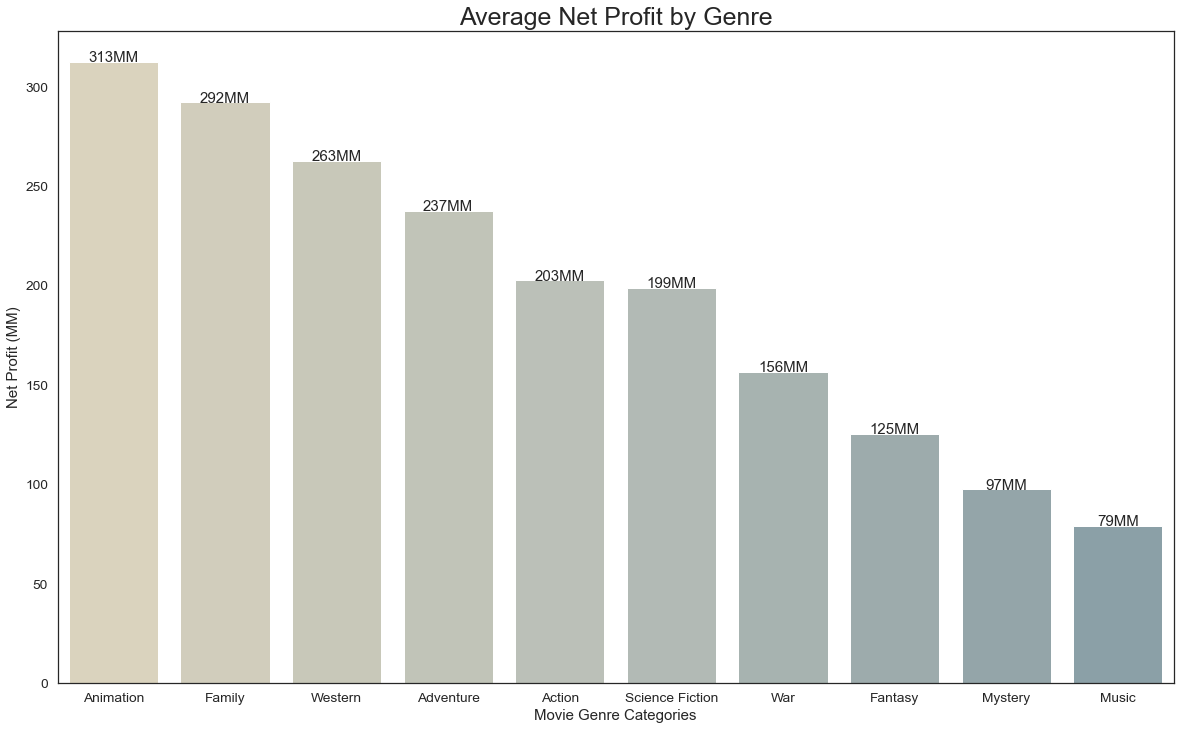

In [46]:
yjoin = df_tmdb_tn_innerjoin.groupby(['primary_genre']).mean().sort_values(by='profit_mils', ascending=False)[:10]
xjoin = list(df_tmdb_tn_innerjoin.groupby(['primary_genre']).mean().sort_values(by='profit_mils', ascending=False).index)[:10]
fig2, axj = plt.subplots(figsize=(20, 12))

sns.barplot(x=xjoin, y=yjoin['profit_mils'], saturation=.4, palette='blend:#EDA,#7AB')

axj.set_title('Average Net Profit by Genre', fontsize=25)
axj.set_xlabel('Movie Genre Categories')
axj.set_ylabel('Net Profit (MM)')


for loc, label in enumerate(yjoin['profit_mils']):
    axj.text(loc, label+.15, (str(int(round(label, ndigits=0))) + 'MM'), ha='center');
    
plt.savefig(fname='figure1')

### 2. The Numbers (TN)<a class="anchor" id="TN_model"></a>

First, we used a scatter plot and Pearson's correlation to examine the relationship between production budget and global net profit.

#### 2.1 Relationship between Production Budget and Global Net Profit<a class="anchor" id="tn_first"></a>

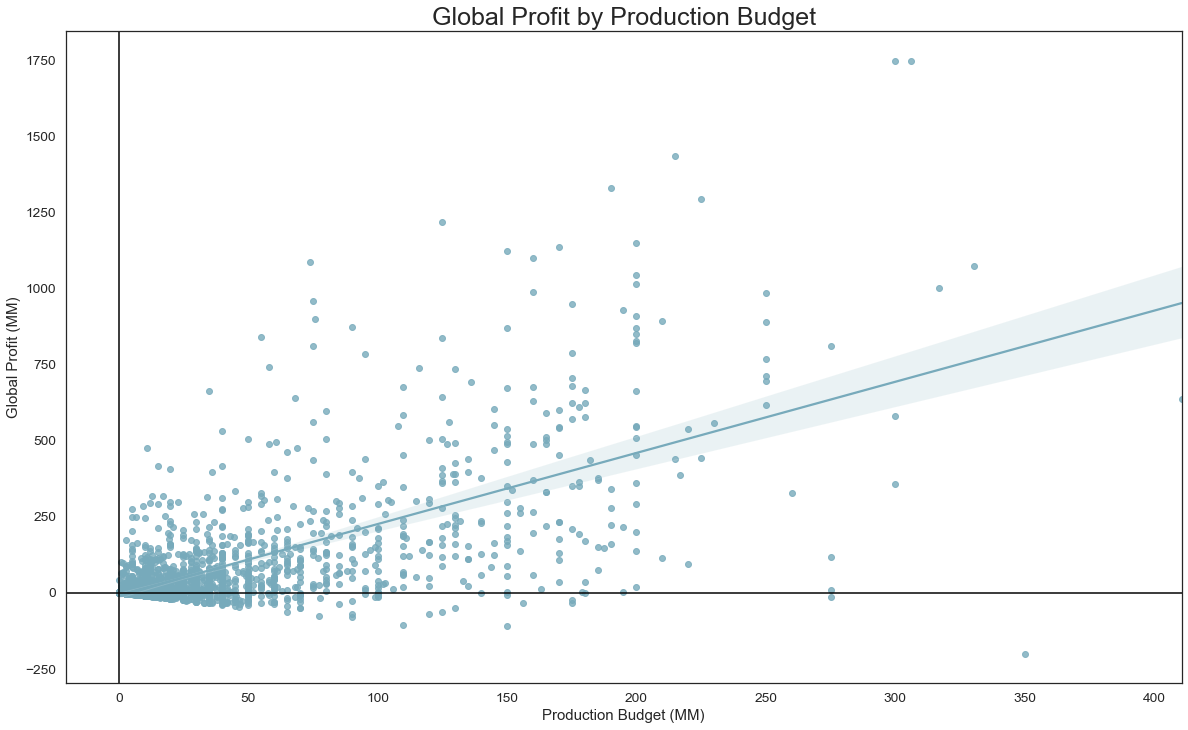

In [37]:
sns.set_theme(context='notebook', palette='blend:#7AB,#7AB', style='white', font='sans-serif', font_scale=1.25, 
              color_codes=True, rc={'figure.figsize':(20,12)})

plot = sns.regplot(x='budget_mils', y='profit_mils', data=tn_df)
plt.axvline(0, color='black')
plt.axhline(0, color='black')

plot.set_title('Global Profit by Production Budget', fontsize=25)
plot.set_xlabel('Production Budget (MM)')
plot.set_ylabel('Global Profit (MM)');

plt.show()

In [38]:
r_budget_profit = tn_df.corr()['production_budget']['net_profit']

print("r = " + str(round(r_budget_profit, 2)))

r = 0.67


- Our scatter plot and Pearson's correlation (r = 0.67) suggests a moderately strong relationship between production budget and profit. 


- From the scatterplot, we determined that high-budget films are high-risk, high-reward. While there is a general positive relationship between budget and profit, there is more variability and a greater range in profits among higher-budget films. 


- Since Microsoft wants to increase their likelihood of producing movies that are box office successes, this brought us to the question: What is the return on investment percentage based on three budget categories defined by economists?

#### 2.2 Budget-Profit Relationship in Low, Medium and High Budget Movies<a class="anchor" id="tn_second"></a>

- Economic researchers define "low", "medium", and "high" budget movies in Hollywood as the following:
  - Low = 0 - 20 mil, 
  - Medium = 20 - 100 mil
  - High = 100+ mil
      - Reference: (Kuehn & Lampe, 2020; https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3751648)

- Below, we group the dataset into these industry standards for "Low", "Medium", and "High" budget movies:

In [39]:
labels = ["Low", "Medium", "High"]
tn_df['budget_groups'] = pd.cut(tn_df['budget_mils'], bins=[0,20,100,500],
                                include_lowest=True, labels=labels)

tn_df.head(3)

,release_date,movie,production_budget,worldwide_gross,net_profit,budget_mils,profit_mils,roi,budget_groups
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,635063875,410.6,635.063875,154.667286,High
2,2019-06-07,Dark Phoenix,350000000,149762350,-200237650,350.0,-200.237650,-57.210757,High
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,1072413963,330.6,1072.413963,324.384139,High


Now, we investigate which budget group has the best ROI. We used the median ROI because we're interested in seeing the ROI for a 'typical' movie across budget groups. There are extreme outliers in each budget group that might misrepresent how a 'typical' movie would fare. The median is less influenced by these extreme outliers.

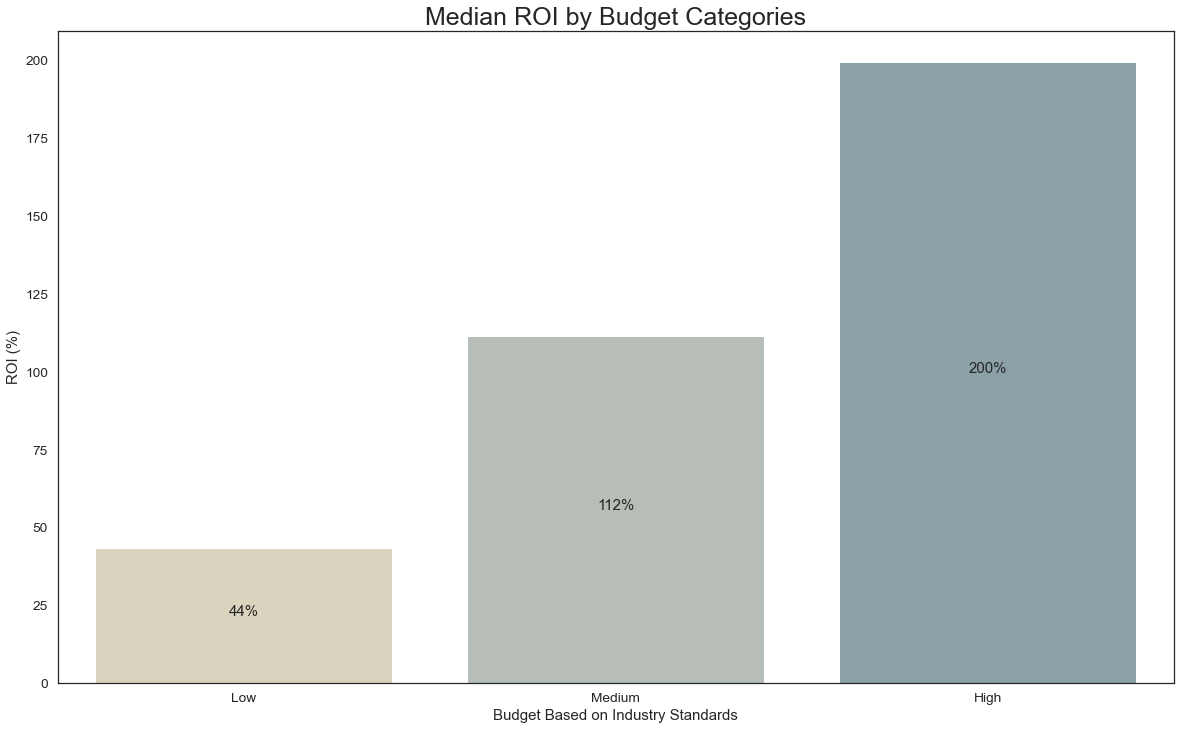

In [47]:
roi_x = list(tn_df.groupby('budget_groups')['roi'].median().index)
roi_y = tn_df.groupby('budget_groups')['roi'].median()
fig3, roi_bar = plt.subplots(figsize=(20, 12))

roi_bar = sns.barplot(x =roi_x, y = roi_y, data = tn_df, saturation=.4, palette='blend:#EDA,#7AB')

roi_bar.set_xlabel("Budget Based on Industry Standards")
roi_bar.set_ylabel("ROI (%)")
roi_bar.set_title('Median ROI by Budget Categories', fontsize=25)

for loc, label in enumerate(roi_y):
    roi_bar.text(loc, label/2, (str(int(round(label, ndigits=0))) + '%'), ha='center');
    
plt.savefig(fname='figure2')

### 3. IMDb<a class="anchor" id="imdb_model"></a>

#### Runtime minute analysis

We want to determine if there is a viewer preference for the number of runtime minutes given that a movie has an average rating of 8.0 and above.  As you can see from the cell below, we still have some movies that have `null` values for `runtime_minutes`.  As such, we will drop those records.  

**Drop the movies with no runtime minutes**

Creating new table `main_data_dropna`.

In [41]:
main_data_dropna = movies_over_median_votes.dropna(subset=['runtime_minutes'])

After dropping the rows with `null` for `runtime_minutes`, we now have a dataset with roughly 35K movies remaining. 

For the next step, we are further narrowing the dataset to include only the highest rated movies (> 8.0). This allows us to find the most common movie length for highly rated films. For this analysis, we will use a histogram.  

Creating final new table `main_data_dropna_best_rated`.

In [42]:
main_data_dropna_best_rated = main_data_dropna.loc[(main_data_dropna['averagerating'] >= 8.0) 
                                                   & (main_data_dropna['runtime_minutes'] < 250)]

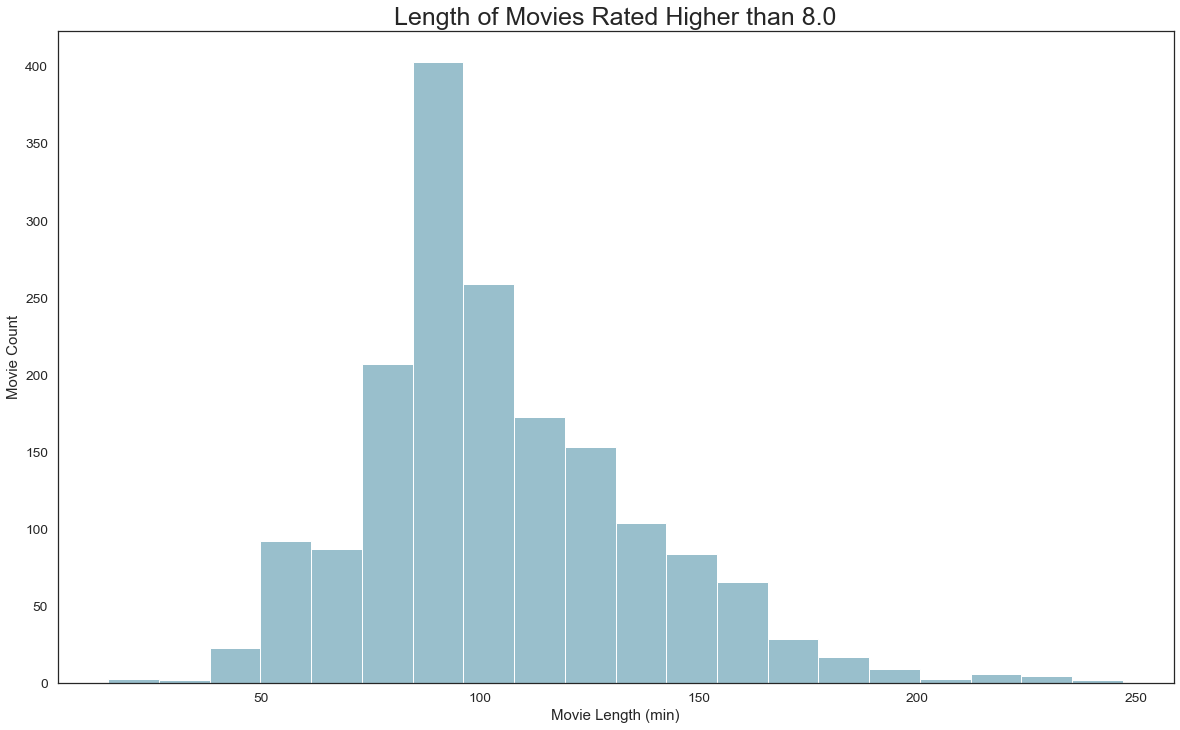

In [48]:
sns.set_theme(context='notebook', palette='blend:#7AB,#7AB', style='white', font='sans-serif', 
              font_scale=1.25, color_codes=True, rc={'figure.figsize':(20,12)})

hist = sns.histplot(main_data_dropna_best_rated['runtime_minutes'], bins=20)

hist.set(xlabel='Movie Length (min)', ylabel='Movie Count');
hist.set_title('Length of Movies Rated Higher than 8.0', fontsize=25);

plt.savefig(fname='figure3')

## Conclusions<a class="anchor" id="conclusions"></a> 

#### 1. The MovieDB (TMDB)

- **It is our recommendation to produce movies within the 'animated' or 'family' genres to maximize net profit.** 
    - Movies with the primary genres of 'animated' and ‘family’ have the highest average net profits (coming in at \\$313MM and \\$292MM respectively). 
    
    
    


#### 2. The Numbers (TN)

- **It is our recommendation that Microsoft plans to invest at least 200 MM per film**
    - Our first data modeling using TN suggested that higher budgets can bring in higher profits. This is further supported by our chart showing median Return on Investment (ROI): high budget films have the greatest potential for maximum returns.

#### 3. IMDb

- **It is our recommendation to make movies with a runtime length near 90 minutes.**
    - As demonstrated in our histogram showing movie length for 'highly' rated movies, there were more movies in the 90-100 minute range than any other movie length.  This would indicate a viewer preference for movies with this length.

### Limitations<a class="anchor" id="limits"></a>

One overarching limitation across all databases to note:

- Our Data ends in the year 2019. If this analysis had access to more recent data, we could provide a more accurate representation of the film industry and how it might have changed due to the Covid-19 pandemic

#### 1. The MovieDB (TMDB)

- The number of movies in each genre is not taken into consideration. If there are a limited number of movies for a particular genre, the sample could be skewed high or low.

#### 2. The Numbers (TN)

- We do not take into consideration any sort of rating system for this modeling. While we can show that high-budget films generally earn more profit, we do not know if people actually enjoyed the movies that were produced with a high budget.

#### 3. IMDb

- The runtime length for movies below an average rating of 8.0 are not taken into consideration. We cannot draw specific conclusions that a 90 minute movie will help contribute to a higher rating, rather we can conclude that most higher rated films are within this runtime.

### Future Considerations<a class="anchor" id="future"></a>

1. **Additional research into genres based on viewer rating.** This modeling could use already available data to demonstrate a user preference by comparing average rating across genre's.

2. **Additional analysis comparing production budget to viewer rating.** This modeling could help predict whether higher production values trend towards higher ratings by viewers.

3. **Additional analysis on net profit generated from each film compared to the movie's runtime.** This would allow us to search for a relationship between movies of this length and whether they generate more dollars.